In [59]:
include("PES_models_bonding_features.jl") # need to reload everytime a change occurs

multirestart (generic function with 1 method)

#### Reverse AD experiments

In [52]:
# try reverseDiff and optimize:
f(x, c) = c*x.^2 # model to be optimized, minimizer is c = 1
y = [9., 4., 1., 0, 1., 4.] # actual data
x = [-3., -2., -1., 0., 1., 2.] # input data, try matrix form
c = 2.
println(f(x, c))
f_ls_close(c) = f_least_squares(f, y, x, c) # wrapper for ls
println(f_ls_close(c))
∇f(c) = Zygote.gradient(cc -> f_least_squares(f, y, x, cc[1]), [c])[1] #closure for gradient
∇f(c)

[18.0, 8.0, 2.0, 0.0, 2.0, 8.0]
115.0


1-element Zygote.OneElement{Float64, 1, Tuple{Int64}, Tuple{Base.OneTo{Int64}}}:
 230.0

In [53]:
r = optimize(c -> f_ls_close(c[1]), c -> ∇f(c[1]), [c], Optim.Options(iterations = 10, show_trace=true); inplace=false)

Iter     Function value   Gradient norm 
     0     1.150000e+02     2.300000e+02
 * time: 0.0
     1     0.000000e+00     0.000000e+00
 * time: 0.0


 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.00e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.15e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = Inf ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [54]:
r.minimizer

1-element Vector{Float64}:
 1.0

In [57]:
f(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2

function g!(G, x)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
end

function g2!(G, x, a, b)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1] + a
    G[2] = 200.0 * (x[2] - x[1]^2) + b
end

const c1 = 0.
const c2 = 0.
function g2_wrap!(G, x)
    return g2!(G, x, c1, c2)
end

function g3(x)
    G = Vector{Float64}(undef, length(x))
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
    return G
end

function g_AD(f, x)
    return Zygote.gradient(f, x)[1]
end

x0 = [0.0, 0.0]
#optimize(f, g!, x0)
#optimize(f, g2_wrap!, x0)
#optimize(f, x -> g2!(zeros(length(x0)), x, 0., 0.), x0) #<<---- doesnt work
r = optimize(f, x -> g_AD(f, x), x0; inplace = false)

 * Status: success

 * Candidate solution
    Final objective value:     5.191703e-27

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.58e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.58e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.41e-19 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.50e+07 ≰ 0.0e+00
    |g(x)|                 = 1.44e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    24
    f(x) calls:    67
    ∇f(x) calls:   67


In [58]:
r.minimizer

2-element Vector{Float64}:
 0.999999999999928
 0.9999999999998559

#### NLS experiments

In [19]:
# t: array of independent variables
# p: array of model parameters

# when the gradients are large, the optimization using the AD gives incorrect result (?)
m(t, p) = p[1] * exp.(p[2] * t)
∇m(t, p) = Zygote.jacobian(p -> m(t,p), p)[1] # extract tuple
function j_m(t,p)
    J = Array{Float64}(undef, length(t),length(p))
    J[:,1] = exp.(p[2] .* t)       #df/dp[1]
    J[:,2] = t .* p[1] .* J[:,1]   #df/dp[2]
    return J
end
p0 = [0.5, 0.5]
tdata = collect(LinRange(0,10,20))
#ydata = m(tdata, [1., 3.1])
ydata = m(tdata, [5.0, 1.3]) + 0.01*randn(length(tdata))
display(∇m(tdata, p0))
display(j_m(tdata, p0))
fit = LsqFit.curve_fit(m, ∇m, tdata, ydata, p0, show_trace=true)

20×2 Matrix{Float64}:
   1.0        0.0
   1.30103    0.342377
   1.69268    0.890887
   2.20224    1.73861
   2.86518    3.01598
   3.72769    4.90486
   4.84985    7.65765
   6.30981   11.6233
   8.20926   17.2827
  10.6805    25.296
  13.8957    36.5676
  18.0787    52.3332
  23.521     74.2769
  30.6016   104.69
  39.8137   146.682
  51.7989   204.469
  67.392    283.756
  87.6792   392.249
 114.073    540.348
 148.413    742.066

20×2 Matrix{Float64}:
   1.0        0.0
   1.30103    0.342377
   1.69268    0.890887
   2.20224    1.73861
   2.86518    3.01598
   3.72769    4.90486
   4.84985    7.65765
   6.30981   11.6233
   8.20926   17.2827
  10.6805    25.296
  13.8957    36.5676
  18.0787    52.3332
  23.521     74.2769
  30.6016   104.69
  39.8137   146.682
  51.7989   204.469
  67.392    283.756
  87.6792   392.249
 114.073    540.348
 148.413    742.066

     0     6.563241e+12              NaN
 * lambda: 10.0

     1     6.563241e+12     2.591640e+09
 * g(x): 2.591639831896396e9
 * lambda: 100.0
 * dx: [827.2528594140493, 186.65296930465558]

     2     6.563241e+12     2.591640e+09
 * g(x): 2.591639831896396e9
 * lambda: 1000.0
 * dx: [97.63461675034387, 21.874448168886328]

     3     6.563241e+12     2.591640e+09
 * g(x): 2.591639831896396e9
 * lambda: 10000.0
 * dx: [9.941935375987685, 2.2258594349669005]

     4     6.549845e+12     2.588725e+09
 * g(x): 2.5887246969161644e9
 * lambda: 1000.0
 * dx: [0.9960135074347357, 0.22297767231505491]

     5     6.499931e+12     6.742224e+10
 * g(x): 6.742224053495961e10
 * lambda: 100.0
 * dx: [1.2995437184614391, 0.09237352055623797]

     6     5.318620e+12     2.800727e+11
 * g(x): 2.8007268411030835e11
 * lambda: 10.0
 * dx: [5.32511323366581, 0.20012922601423036]

     7     2.636252e+12     4.046490e+12
 * g(x): 4.046490185259882e12
 * lambda: 1.0
 * dx: [6.003533139723561, 0.076392

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([4.99999973538031, 1.3000000049905103], [0.005639923605063046, 0.0025056999401904534, 0.02249913494525302, -0.0013100915160677573, 0.0021325678440717866, 0.0025457911105206676, -0.016281799101136585, 0.002396355397991101, 0.006985252297454281, 0.011781346100633527, -0.009414996458872338, 0.009993928209951264, 0.008879334560333518, 0.0015716631460236385, -0.007188250237959437, 0.002912021445808932, -0.01138766430085525, 0.007999738678336143, -0.0004891338758170605, -0.00041779782623052597], [1.0 0.0; 1.982206323132747 5.216332153227849; … ; 223192.41388979173 1.0572271677358592e7; 442413.41408760665 2.2120669533667326e7], true, Float64[])

In [18]:
fit.param

2-element Vector{Float64}:
 5.000001548777902
 1.2999999687649013

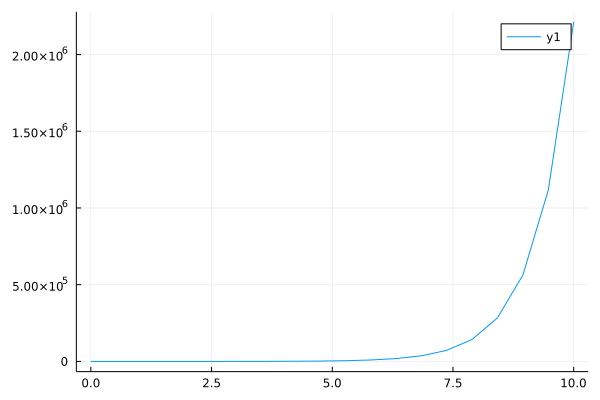

In [4]:
plot(tdata, ydata)

In [60]:
# main caller for tchebyshev primitive
H_data = readdlm("data/h3/h3_data.txt")
# load atomic coordinates:
X = npzread("data/h3/h3_coord.npy")
R = H_data[:,1:end-1]; V = H_data[:, end]
n_atom, n_basis, g, e = (3, 59, 6, 3)
r_xy, N, max_deg = (1.4172946, 5, 5)
idxer = atom_indexer(n_atom)
R_h = 0.01; R_C = 2.; R_0 = .9; C = 1.; g = 6

6

In [61]:
U = f_U_bas(R, idxer, C, R_h, R_C, R_0, g)
display(U)

6032×3 Matrix{Float64}:
 -0.300863  -0.282625  -0.184308
 -0.253721  -0.252811  -0.107353
 -0.315268  -0.274512  -0.274512
 -0.315268  -0.245936  -0.245936
 -0.258908  -0.24448   -0.188119
 -0.258908  -0.218936  -0.162575
 -0.211765  -0.196005  -0.0925023
 -0.181165  -0.17877   -0.0446662
 -0.202547  -0.192171  -0.192171
 -0.202547  -0.164519  -0.164519
 -0.202547  -0.142758  -0.142758
 -0.155405  -0.143337  -0.0961947
 -0.155405  -0.126515  -0.079373
  ⋮                    
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.303784   0.303784   0.0
  0.363654   0.363654   0.0
  0.232722   0.232722   0.0
  0.322665   0.322665   0.0
  0.384724   0.384724   0.0
  0.416416   0.416416   0.0
  0.293148   0.293148   0.0
  0.418347   0.418347   0.0

In [78]:
Vref_map(R, C, R_h, R_C, R_0, g) = V_ref_pairpot.(R, C, R_h, R_C, R_0, g)
V = Vref_map(R, C, R_h, R_C, R_0, g)
display(V)
#dV = Zygote.jacobian(a -> Vref_map(R, a, R_h, R_C, R_0, g), C)[1] #why all 0???

6032×3 Matrix{Float64}:
 -155.932    -79.1213  -64.8722
 -155.932    -42.2907  -41.5799
 -123.154   -123.154   -91.3125
 -123.154   -123.154   -68.9869
 -123.154    -79.1213  -67.8494
 -123.154    -79.1213  -47.8925
 -123.154    -42.2907  -29.978
 -123.154    -18.3835  -16.5126
  -79.1213   -79.1213  -71.0151
  -79.1213   -79.1213  -49.4112
  -79.1213   -79.1213  -32.4104
  -79.1213   -42.2907  -32.8627
  -79.1213   -42.2907  -19.7205
    ⋮                  
    0.0        0.0       0.0
    0.0        0.0       0.0
    0.0        0.0       0.0
    0.0        0.0       0.0
  237.335      0.0       0.0
  284.11       0.0       0.0
  181.817      0.0       0.0
  252.086      0.0       0.0
  300.571      0.0       0.0
  325.331      0.0       0.0
  229.026      0.0       0.0
  326.839      0.0       0.0

18096-element Vector{Real}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [80]:
filter(x -> x>0, dV)

Real[]

In [ ]:
function f_U_bas(R, idxer, arg_vref...)
    """
    U = ∑V_ij
    returns matrix (n_data, n_atom) ∈ Float64
    params:
        - R, matrix of distances, shape = (n_data, n_d) ∈ Float64
        - idxer, matrix containing the atomic indexer, shape = (n_atom-1,n_atom) ∈ Int
        - all params of V_ref_pairpot (arg_vref...)
    """
    n_data = size(R)[1]; n_atom = size(idxer)[2]
    Vref = V_ref_pairpot.(R, arg_vref...)
    U = Matrix{Float64}(undef, n_data, n_atom)
    #U = zeros(n_data, n_atom)
    @simd for i=1:n_atom
        Vsub = @view Vref[:, idxer[:,i]]
        U[:, i] = sum(Vsub, dims=2)
    end
    U = U./maximum(abs.(U)) # scale U, by U:=U/max(abs(U))
    return U
end